Strategy: 

    First we will use an LDA model to extract 'topic' features.
    Music is a language right?  Notes are words, songs are documents
    (probably should use Chords instead of notes but I don't know enough about music).
    
    Then we will use these LDA features and other music features to train classifier models.
    Model 1 identifies composer (should be easier)
    Model 2 identifies the score, and composer can be found from that

    
    Once score has been identified, match the piece of interest:
        E.g. piece of interest (PI) [A, B, C], Score [B, C, D, A, B, C, A, B, D]
        Move the PI across the score, each time counting a distance metric (see below) between each note in the PI and the corresponding note in the full song.
        The place with the smallest distance is the best match

In [1]:
import music21, os
import numpy, pandas
import scipy.stats as stats
from random import randint
from collections import Counter
from music21 import *
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from gensim import corpora, models, similarities, matutils
import gensim.parsing.preprocessing as preprocess
import gensim.matutils as mat
from matplotlib import pyplot as plt

#Grab the data and process it so it's useful

In [ ]:
# Grab all data files and extract music features from them
scoreFiles = []
composers = []
for root, dirnames, filenames in os.walk(os.getcwd()+'/musicDB'):
  for filename in filenames:
    scoreFiles.append(os.path.join(root, filename))
    
    cmpStartIdx = scoreFiles[-1].find('musicDB')+8
    cmpEndIdx = scoreFiles[-1].find('\\', cmpStartIdx)
    composers.append(scoreFiles[-1][cmpStartIdx:cmpEndIdx])

notes = []
sigs = []
keys = []
instruments = []
durations = []
ambitus = []
scores = []
scoreIDs = []
i = 0
for scoreFile in scoreFiles:
    i+=1
    #if i % 20 == 0:
    #    print(i)
    parsedScore = converter.parse(scoreFile)
    notes.append([str(p) for p in parsedScore.pitches])
    sigs.append([str(s)[29:-1] for s in parsedScore.flat.getTimeSignatures()])
    keys.append(parsedScore.analyze('key'))
    instruments.append([str(inst) for inst in parsedScore.flat.getInstruments(returnDefault=False)])
    durations.append(parsedScore.highestTime)
    ambitus.append(parsedScore.analyze('ambitus'))
    scores.append(scoreFile)
    scoreIDs.append(i-1)
    
import dill
with open('musicData.pickle','wb') as f:
    dill.dump([scores, scoreIDs, notes, composers, sigs, keys, instruments, durations, ambitus], f)

In [2]:
import dill
with open('musicData.pickle','rb') as f:
    scores, scoreIDs, notes, composers, sigs, keys, instruments, durations, ambitus = dill.load(f)

In [3]:
#ComposersID dictionary
compDict = {}
compId = 1
for c in set(composers):
    compDict[c] = compId
    compId += 1


#KeysIDs Dict
keyStr = []
for k in keys:
    keyStr.append(str(k))
keyDict = {}
keyId = 1
for k in set(keyStr):
    keyDict[k] = keyId
    keyId += 1

#AmbitusIDs Dict
ambitusStr = []
for a in ambitus:
    ambitusStr.append(str(a)[27:-2])
ambitusDict = {}
ambitusId = 1
for a in set(ambitusStr):
    ambitusDict[a] = ambitusId
    ambitusId += 1

allsigs =  []
for s in sigs:
    allsigs += s
sigDict = {}
sigId = 1
for s in set(allsigs):
    sigDict[s] = sigId
    sigId += 1
    
#InstrumentsID dictionary
allinst = []
for inst in instruments:
    allinst += inst
instDict = {}
instId = 1
for inst in set(allinst):
    instDict[inst] = instId
    instId += 1


#Use the data to train the LDA model

We use all of the data to train the model.  Notes are words, and scores are documents.  We decide on 15 topics.  There are methods to determine the optimal number of topics but I will not use them for this analysis.

In [4]:
dictionary = corpora.Dictionary(notes)
corpus = [dictionary.doc2bow(text) for text in notes]

n_topics = 15
lda = models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = n_topics, update_every = 1, chunksize = 100, passes = 5)


In [5]:
lda.save('ldamodel')

In [6]:
def classify_score(score,ldamodel):
    dictionaryS = corpora.Dictionary(score)
    corpusS = [dictionary.doc2bow(text) for text in score]
    return lda.inference(corpusS)[0][0]

In [7]:
def mostCommon(myList):
    counts = Counter(myList)
    return counts.most_common(1)[0][0]


We now have our LDA model.  We can use it to determine topics in subsets of scores.  Then we can feed these and other features into the RF classifier.  One thing to note is that topic coefficient magnitude might not be as interesting as max topic.  So in addition to the coefficietn magnitude we will generate 3 more features, FirstTopic, SecondTopic, and ThirdTopic, that will contain topic IDs of the 3 highest coefficients. 

In [80]:
#This REALLY wants to be a function - but for now we'll leave it like this
#For each score, we want to pick out several random pieces of random length.
useInstruments = 0  #Instruments are not consistently named therefore it's cheating to use them
                    #they are too unique between scores even if instruments are the same.

notesArray = numpy.array(notes)
composersArray = numpy.array(composers)
sigsArray = numpy.array(sigs)
keysArray = numpy.array(keyStr)
instrumentsArray = numpy.array(instruments)
durationsArray = numpy.array(durations)
ambitusArray = numpy.array(ambitusStr)
scoresArray = numpy.array(scores)
scoreIDsArray = numpy.array(scoreIDs)

features = []
classes = []
pieceScores = []  #We'll store the piece notes in this array so they get split later when we split to test and training sets
                  #We'll also need to either use an ID column in classes OR set the random_state when we split the data
                  #This is hacky and shouldn't done this way but.. Shhhh!  Don't look here! 
minLength = 20 #mininum length of score piece
numPieces = 20 #number of random pieces to sample from each score
for scoreID in scoreIDsArray:
    for s in range(0,numPieces):
        features.append([])
        classes.append([])

        #Classification
        classes[-1].append(compDict[composersArray[scoreID]]) #Composer ID
        classes[-1].append(composersArray[scoreID]) #Composer Name
        classes[-1].append(scoresArray[scoreID]) # Score file
        classes[-1].append(scoreIDsArray[scoreID]) # Score ID

        startIdx = randint(0,len(notesArray[scoreID])-minLength)
        endIdx = randint(startIdx+minLength, len(notesArray[scoreID]))
    
        pieceScores.append([notesArray[scoreID][startIdx:endIdx]])
        #LDA Features
        topicCoeffs = classify_score([notesArray[scoreID][startIdx:endIdx]], lda)
        for coeff in topicCoeffs:
            features[-1].append(coeff)
        top3topics = numpy.argsort(topicCoeffs)[::-1][0:3]
        for topic in top3topics:
            features[-1].append(topic)

        features[-1].append(sigDict[mostCommon(sigsArray[scoreID])])
        features[-1].append(keyDict[keysArray[scoreID]])
        features[-1].append(ambitusDict[ambitusArray[scoreID]])
        
        if useInstruments == 1:
            for k in instDict.keys():
                features[-1].append(instrumentsArray[scoreID].count(k))
        #duration =  you won't know the duration of the total song in test data
        #density =  need note durations to calculate this

classesArray = numpy.array(classes)
featuresArray = numpy.array(features)

featureLabels = []
for t in range(0,n_topics):
    featureLabels.append('topic' + str(t))
featureLabels.append('FistTopic')
featureLabels.append('SecondTopic')
featureLabels.append('ThirdTopic')
featureLabels.append('Time Signature')
featureLabels.append('Key')
featureLabels.append('Ambitus')
if useInstruments == 1:
    for k in instDict.keys():
        featureLabels.append('Instrument: ' + k)

    

We will split the data into training sets to train our classifiers, and a test set to validate the models.

In [81]:
train_features, test_features, train_classes, test_classes = train_test_split(featuresArray, classesArray, random_state = 0)

#Shhh!  Stop looking at anything with pieceScores
train_pieceScores, test_pieceScores, junk, junk = train_test_split(pieceScores, pieceScores, random_state = 0) 

#Composer Classification

Here we use a random forest to classify the composers.  First we'll try using ONLY the LDA features.  Then we'll use the additional features from the scores like keys, time signiture, and ambitus.

In [10]:
#First let's fit only LDA features
XVar = train_features[:,0:18] #Train on LDA features
YVar = train_classes[:,0]

composerForest=ensemble.RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)        
composerForest.fit(XVar,YVar); 

In [11]:
chanceLevel1 = 213/783 #if you always pick palestrina he has 213 of the 783 files
#composerForest.oob_score_
correct = sum(composerForest.predict(test_features[:,0:18])==test_classes[:,0])
total = len(test_classes)
percentCorrect = correct/total
percentCorrect

0.71289910600255424

We got 70% accuraccy.  Not too shabby.  Chance levels here are 27%, calculated both by the number of files that classify as the most prolific composer, and verified by training a random forest on independent features and then having it classify (not shown).

So 70% is much better than 27%, but it's not great.  Let's now add in the other features.

In [12]:
#Now let's add time signature, ambitus, key, and ambitus
XVar = train_features #Train on all features
YVar = train_classes[:,0]

composerForest=ensemble.RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)        
composerForest.fit(XVar,YVar); 

In [13]:
correct = sum(composerForest.predict(test_features)==test_classes[:,0])
total = len(test_classes)
percentCorrect = correct/total
percentCorrect

0.95197956577266918

About 95% accuracy, that's pretty good!  Let's find out what features are important.

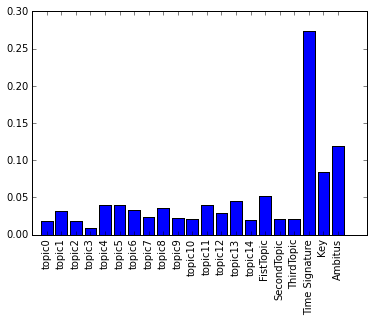

In [15]:
plt.bar(range(0,len(composerForest.feature_importances_)),composerForest.feature_importances_, align='center')
plt.xticks(range(0,len(composerForest.feature_importances_)), featureLabels, rotation='vertical');
plt.xlim([-1,22]);

The time signature seems to be very important.  That seems odd to me, as I would guess composers like to change time signatures often.  Maybe the songs I selected had a correlation between time signatures and composers that they should not have.  Normally I would look into this but this time I'll ignore it.  

The LDA features don't do great, but they do ok.  FirstTopic does the best, as expected.  And if you consider them together, they actually do quite a bit of work (they can predict with 70% accuracy after all)

#Score Prediction

We now need to find what song a piece of music came from.  We had good luck with random forests before, why not try one again?

In [16]:
XVar = train_features #Train all features
YVar = train_classes[:,3]
  
scoreForest=ensemble.RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)        
scoreForest.fit(XVar,YVar); 

In [17]:
scoreForest.oob_score_

0.65508727117922516

In [18]:
correct = sum(scoreForest.predict(test_features)==test_classes[:,3])
total = len(test_classes)
percentCorrect = correct/total
percentCorrect

0.6498084291187739

Random forest does ok - at about 65%.  This is MUCH higher than chance which is (about 0.1%).  We need more trees but that takes too much memory. 

One issue is that some songs are broken up into multiple files.  The algorithm has no way to know which file a part of a song came from and as a result gets it wrong.  Combining the files appropriately may help, but this is tricky to do with classical music (e.g. we should probably NOT combine different movements of the same song).  

We can try to improve by training random forests separately for each composer.  

In [19]:
class RF_Container: pass
composerScoreForests=RF_Container()  

for c in set(composers):
    compIdx = numpy.where(numpy.array(train_classes[:,0])==str(compDict[c]))[0]
    XVar = train_features[compIdx,:] #Train all features
    YVar = train_classes[compIdx,3]
    composerScoreForest=ensemble.RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)        
    composerScoreForest.fit(XVar,YVar)  
    setattr(composerScoreForests, 'CID' + str(compDict[c]), composerScoreForest)
   

In [20]:
sID=[]
cID=[]
for sample in range(0,len(test_features)):
    cID.append(composerForest.predict(test_features[sample,:].reshape(1,-1)))
    rf = getattr(composerScoreForests,'CID' + str(cID[-1][0]))
    sID.append(rf.predict(test_features[sample,:].reshape(1,-1))[0])

In [21]:
percentCorrect = sum(sID==test_classes[0:len(sID),3])/len(sID)
percentCorrect

0.64086845466155806

Not much of a change unfortunately.  However, this DOES train MUCH more quickly.

#Determine Location of Song Sample in Song

Now we will attempt to match the location in the song from where the sample is taken from.

To do this we will first define a numberline of notes ordered by their frequency
e.g. [A10 B10 C10.... A6 B6 C6 ...A1 B1 C1]
Each will be mapped to a number, in order of frequency

We will then take our song sample piece and move it through the score file identified by the random forest and at each location we will determine how far each note is in the sample from the aligned note in the full song

e.g.
Piece [A, B, C]
Song [B, A, B, A, B, C, A, B, A]
Piece will move along Song, and at each location we will calculate the difference in each aligned note based on the numberline.
The smallest absolute difference will be the location where the piece fits.

In [41]:
def generateNoteValDict():  #Generate a dictionary with note values
    noteLetters = ['A','B','C','D','E','F','G']
    noteValDict = {}
    noteVal = 1
    for i in range(8,0,-1):
        for l, L in enumerate(noteLetters):
            if L == 'A':
                noteValDict['F##' + str(i+1)] = noteVal
                noteVal += 1
                noteValDict['G#' + str(i+1)] = noteVal
                noteVal += 1
            elif L == 'B':
                noteValDict['G##' + str(i+1)] = noteVal
                noteVal += 1
                noteValDict['A#' + str(i)] = noteVal
                noteVal += 1
            else:
                noteValDict[noteLetters[l-2] + '##' + str(i)] = noteVal
                noteVal += 1
                noteValDict[noteLetters[l-1] + '#' + str(i)] = noteVal
                noteVal += 1

            noteValDict[L + str(i)] = noteVal
            noteVal += 1

            if L == 'F':
                noteValDict['G-' + str(i)] = noteVal
                noteVal += 1
                noteValDict['A--' + str(i-1)] = noteVal
                noteVal += 1
            elif L == 'G':
                noteValDict['A-' + str(i-1)] = noteVal
                noteVal += 1
                noteValDict['B--' + str(i-1)] = noteVal
                noteVal += 1
            else:
                noteValDict[noteLetters[l+1] + '-' + str(i)] = noteVal
                noteVal += 1
                noteValDict[noteLetters[l+2] + '--' + str(i)] = noteVal
                noteVal += 1
                
    return noteValDict

noteValDict = generateNoteValDict()

In [117]:
def pieceLocation(sample, score):  #Calculate distance metric
    minDist = 99999999999999
    minIdx = -1  
    
    sampleVals = numpy.array([noteValDict[x] for x in sample])
    scoreVals = numpy.array([noteValDict[x] for x in score])
    
    for i in range(0, len(score)-len(sample)):
        sampleDist = sum(numpy.abs(sampleVals-scoreVals[i:i+len(sample)]))
        if sampleDist < minDist:
            minDist = sampleDist
            minIdx = i
    return [minIdx, minDist]

In [130]:
def analyzePiece(sampleFeatures,sampleScore): #Analyze a song sample

    pieceCompID = composerForest.predict(sampleFeatures)
    for c, compId in compDict.items():
        if compId == int(pieceCompID[0]):
            pieceComposer = c
        
    pieceScoreID = scoreForest.predict(sampleFeatures)
    pieceScoreFile = scores[int(pieceScoreID[0])]
    
    fullScore = notesArray[int(pieceScoreID[0])]
    minIdx, minDist = pieceLocation(sampleScore, fullScore)

    return [pieceComposer, pieceScoreFile, minIdx, minDist, fullScore]

In [149]:
def printResults(predComposer,predScoreFile,matchIdx,matchDistance, fullScore, testPiece):  #Print analysis results from song sample
    print('Predicted Composer: ' + predComposer)
    print('Actual Composer: ' + test_classes[sampleID,1])
    print('Predicted ScoreFile: ' + predScoreFile)
    print('Actual ScoreFile: ' + test_classes[sampleID,2])
    print('Match Distance: ' + str(matchDistance))

    for i in range(max(0,matchIdx-5),max(0,matchIdx-5)+15):
        if i < matchIdx:
            print(fullScore[i] + '|')
        else:
            print(fullScore[i] + '|' + testPiece[i-matchIdx])
    print('...\n...\n...')
    for i in range(matchIdx+len(testPiece)-15,min(len(fullScore),matchIdx+len(testPiece)+5)):
        if i-matchIdx >= len(testPiece):
            print(fullScore[i] + '|')
        else:
            print(fullScore[i] + '|' + testPiece[i-matchIdx])

##Correctly Classified Song

Let's look at a correctly classified song.  Everything matches, and the Match Distance is 0.  You can see the notes of the full score on the left side, and the notes of the sample on the right side.

In [148]:
sampleID = 1
testPiece = test_pieceScores[sampleID][0]
predComposer, predScoreFile, matchIdx, matchDistance, fullScore = analyzePiece(test_features[sampleID,:].reshape(1,-1),testPiece)
            
printResults(predComposer,predScoreFile,matchIdx,matchDistance, fullScore, testPiece)

Predicted Composer: bethoveen
Actual Composer: bethoveen
Predicted ScoreFile: D:\Google Drive\Insight Data Science\Yewno/musicDB\bethoveen\sonatas\sonata02-4.krn
Actual ScoreFile: D:\Google Drive\Insight Data Science\Yewno/musicDB\bethoveen\sonatas\sonata02-4.krn
Match Distance: 0
E6|
E6|
E6|
B-4|
B-4|
B-4|B-4
G5|G5
E5|E5
B-4|B-4
A4|A4
C5|C5
F5|F5
C5|C5
A5|A5
F5|F5
...
...
...
E3|E3
B-3|B-3
C3|C3
B-3|B-3
E3|E3
B-3|B-3
C#3|C#3
A#3|A#3
E3|E3
A#3|A#3
C#3|C#3
A#3|A#3
E3|E3
A#3|A#3
D3|D3
B3|
F#3|
B3|
D3|
B3|


##Incorrectly Classified Song

Let's look at an incorrectly classified song.  You can see a mismatch in the notes, and distance is 511.  You can also see that the composer is correctly matched by both the Composer model and the Score model.

In [152]:
sampleID = 0
testPiece = test_pieceScores[sampleID][0]
predComposer, predScoreFile, matchIdx, matchDistance, fullScore = analyzePiece(test_features[sampleID,:].reshape(1,-1),testPiece)
            
printResults(predComposer,predScoreFile,matchIdx,matchDistance, fullScore, testPiece)

Predicted Composer: mozart
Actual Composer: mozart
Predicted ScoreFile: D:\Google Drive\Insight Data Science\Yewno/musicDB\mozart\sonata\sonata01-3.krn
Actual ScoreFile: D:\Google Drive\Insight Data Science\Yewno/musicDB\mozart\sonata\sonata15-3.krn
Match Distance: 511
D5|
F5|
G5|
B5|
C5|
E5|E5
G5|G5
C6|C6
C4|E4
D4|C5
E4|E4
F4|C5
G4|E4
A4|C5
B4|C4
...
...
...
E4|C5
B3|A3
D4|C4
A3|A3
C4|C4
G3|F3
B3|A3
C4|G3
C5|B3
F4|G3
F#4|B3
G4|E3
G3|G3
E3|F3
G3|D3
D3|
F3|
C3|
E3|
B2|
